Ensemble Mean Squared Error: 0.11
Ensemble Mean Absolute Error: 0.26
Ensemble R^2 Score: 0.95


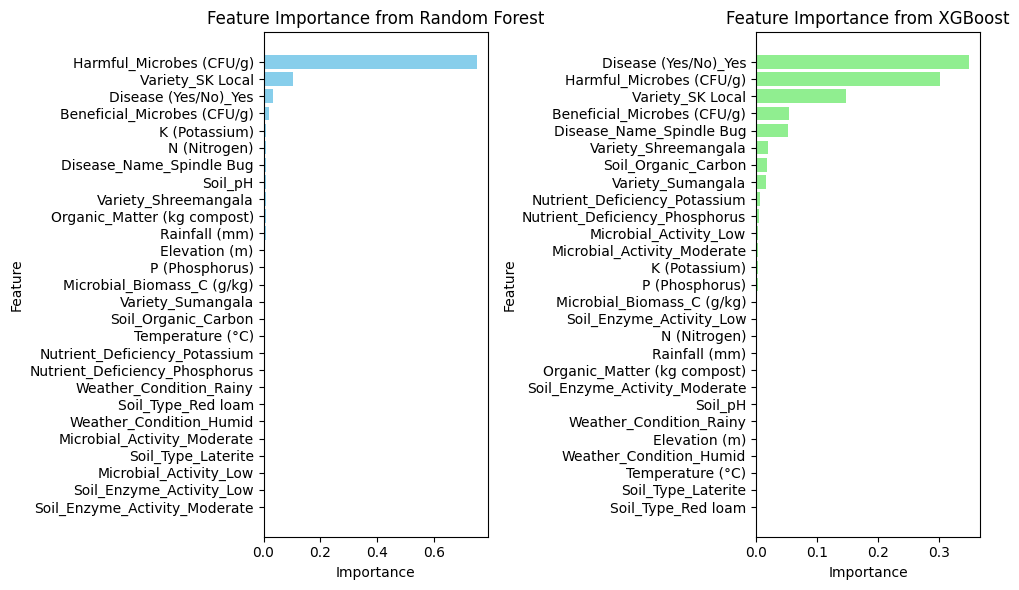

In [1]:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from xgboost import XGBRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import matplotlib.pyplot as plt

    # Load the dataset
    df = pd.read_csv('C:/Users/kunji/OneDrive/Desktop/data/augmented_arecanut_dataset5k.csv')

    # Preprocessing function to convert scientific notation
    def convert_scientific_notation(x):
        if isinstance(x, str) and 'x 10' in x:
            parts = x.split('x 10^')
            return float(parts[0]) * (10 ** int(parts[1]))
        return float(x)

    # Convert scientific notation to float
    df['Beneficial_Microbes (CFU/g)'] = df['Beneficial_Microbes (CFU/g)'].apply(convert_scientific_notation)
    df['Harmful_Microbes (CFU/g)'] = df['Harmful_Microbes (CFU/g)'].apply(convert_scientific_notation)
    df['Soil_Organic_Carbon'] = df['Soil_Organic_Carbon'].str.replace('%', '').astype(float) / 100.0

    # Define numeric columns
    numeric_cols = [
        'Soil_pH', 'N (Nitrogen)', 'P (Phosphorus)', 'K (Potassium)', 
        'Organic_Matter (kg compost)', 'Temperature (°C)', 'Rainfall (mm)', 
        'Elevation (m)', 'Beneficial_Microbes (CFU/g)', 'Harmful_Microbes (CFU/g)', 
        'Microbial_Biomass_C (g/kg)', 'Soil_Organic_Carbon'
    ]

    # Convert to numeric and handle errors
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Fill missing values with column means
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Encode categorical variables
    df = pd.get_dummies(df, drop_first=True)

    # Split data into features and target variable, excluding Sample_ID
    X = df.drop(['Crop_Yield (kg/palm)', 'Sample_ID'], axis=1)
    y = df['Crop_Yield (kg/palm)']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define and train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    rf_model.fit(X_train_scaled, y_train)

    # Define and train the XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    xgb_model.fit(X_train_scaled, y_train)

    # Predicting the yields for test data using both models
    rf_pred = rf_model.predict(X_test_scaled)
    xgb_pred = xgb_model.predict(X_test_scaled)

    # Ensemble predictions (simple average)
    ensemble_pred = (rf_pred + xgb_pred) / 2

    # Calculate and print performance metrics for ensemble
    ensemble_mse = mean_squared_error(y_test, ensemble_pred)
    ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_r2 = r2_score(y_test, ensemble_pred)

    print(f"Ensemble Mean Squared Error: {ensemble_mse:.2f}")
    print(f"Ensemble Mean Absolute Error: {ensemble_mae:.2f}")
    print(f"Ensemble R^2 Score: {ensemble_r2:.2f}")

    # Feature Importances
    rf_feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    xgb_feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plotting feature importances for both models
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.barh(rf_feature_importances['Feature'], rf_feature_importances['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance from Random Forest')
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    plt.barh(xgb_feature_importances['Feature'], xgb_feature_importances['Importance'], color='lightgreen')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance from XGBoost')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


In [4]:
import joblib

# Define a class for the ensemble model
class EnsembleModel:
    def __init__(self, rf_model, xgb_model, scaler):
        self.rf_model = rf_model
        self.xgb_model = xgb_model
        self.scaler = scaler

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        rf_pred = self.rf_model.predict(X_scaled)
        xgb_pred = self.xgb_model.predict(X_scaled)
        # Ensemble predictions (simple average)
        ensemble_pred = (rf_pred + xgb_pred) / 2
        return ensemble_pred

# Create an instance of the ensemble model
ensemble_model = EnsembleModel(rf_model, xgb_model, scaler)

# Dump the ensemble model to a file
joblib.dump(ensemble_model, 'ensemble_model.pkl')

print("Ensemble model dumped successfully!")

Ensemble model dumped successfully!


In [5]:
import pandas as pd
import numpy as np

# Example input for testing with disease conditions
test_input_data = {
    'Variety_SK Local': [1],
    'Variety_Shreemangala': [0],
    'Variety_Sumangala': [0],
    'Variety_Mangala': [0],  # Include Mangala variety only
    'Soil_pH': [6.3],
    'N (Nitrogen)': [115],
    'P (Phosphorus)': [56],
    'K (Potassium)': [154],
    'Organic_Matter (kg compost)': [13.1],
    'Temperature (°C)': [25],
    'Rainfall (mm)': [1763],
    'Elevation (m)': [531],
    'Beneficial_Microbes (CFU/g)': [convert_scientific_notation('2 x 10^7')],
    'Harmful_Microbes (CFU/g)': [convert_scientific_notation('0')],
    'Microbial_Biomass_C (g/kg)': [342],
    'Soil_Organic_Carbon': [2],
    'Microbial_Activity_Low': [0],
    'Microbial_Activity_Moderate': [0],
    'Microbial_Activity_High': [1],
    'Soil_Enzyme_Activity_Low': [0],
    'Soil_Enzyme_Activity_Moderate': [0],
    'Soil_Enzyme_Activity_High': [1],
    'Disease (Yes/No)_Yes': [0],  
    'Disease_Name_Koleroga': [0], 
    'Disease_Name_Spindle Bug': [0],
    'Nutrient_Deficiency_Nitrogen': [0],
    'Nutrient_Deficiency_Phosphorus': [0],
    'Nutrient_Deficiency_Potassium': [0],
    'Weather_Condition_Humid': [1],
    'Weather_Condition_Dry': [0],
    'Weather_Condition_Rainy': [0],
}

# Create a DataFrame for input
input_df = pd.DataFrame(test_input_data)

# Ensure the input DataFrame has the same structure as the training data
input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

# Scale the input using the same scaler as during training
input_scaled = scaler.transform(input_df)

# Predict the yield using the trained Random Forest model
predicted_yield_rf = rf_model.predict(input_scaled)

# Predict the yield using the trained XGBoost model
predicted_yield_xgb = xgb_model.predict(input_scaled)

# Ensemble prediction (simple average)
ensemble_predicted_yield = (predicted_yield_rf + predicted_yield_xgb) / 2

# Output the results
print(f"\nPredicted Crop Yield using Random Forest (kg/palm): {predicted_yield_rf[0]:.2f}")
print(f"Predicted Crop Yield using XGBoost (kg/palm): {predicted_yield_xgb[0]:.2f}")
print(f"Ensemble Predicted Crop Yield (kg/palm): {ensemble_predicted_yield[0]:.2f}")



Predicted Crop Yield using Random Forest (kg/palm): 3.33
Predicted Crop Yield using XGBoost (kg/palm): 3.23
Ensemble Predicted Crop Yield (kg/palm): 3.28
